In [12]:
### Imports
import sys
sys.path.insert(0, '/home/augustsemrau/drive/M1semester/02506_AdvancedImageAnalysis/02505miniproject')

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms as transforms
import torchvision
import torch
import torch.nn as nn

import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init

from PIL import Image

from data_utils import EM_DATA
from U_NET_model import UNet
from model_train import train_model

def set_seed(seed: int):
    torch.manual_seed(seed)
    np.random.seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# U-Net training notebook

## Load Data

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

## Load the dataset
train_dataset = EM_DATA(train=True, size=256, _transform=transform, data_path="Data")
val_dataset = EM_DATA(train=False, size=256, _transform=transform, data_path="Data", validation=True)
test_dataset = EM_DATA(train=False, size=256, _transform=transform, data_path="Data")

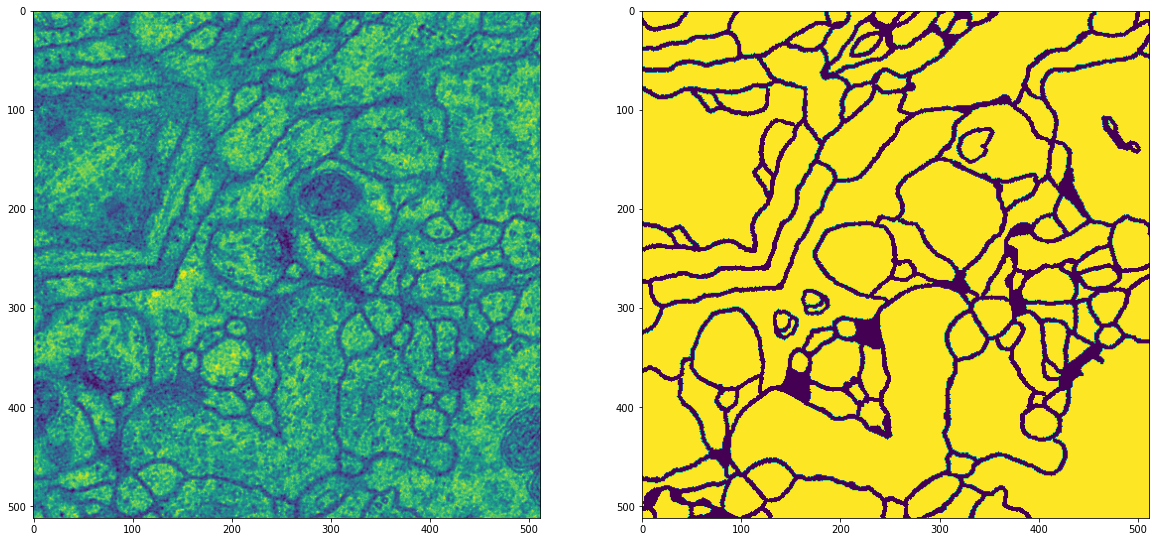

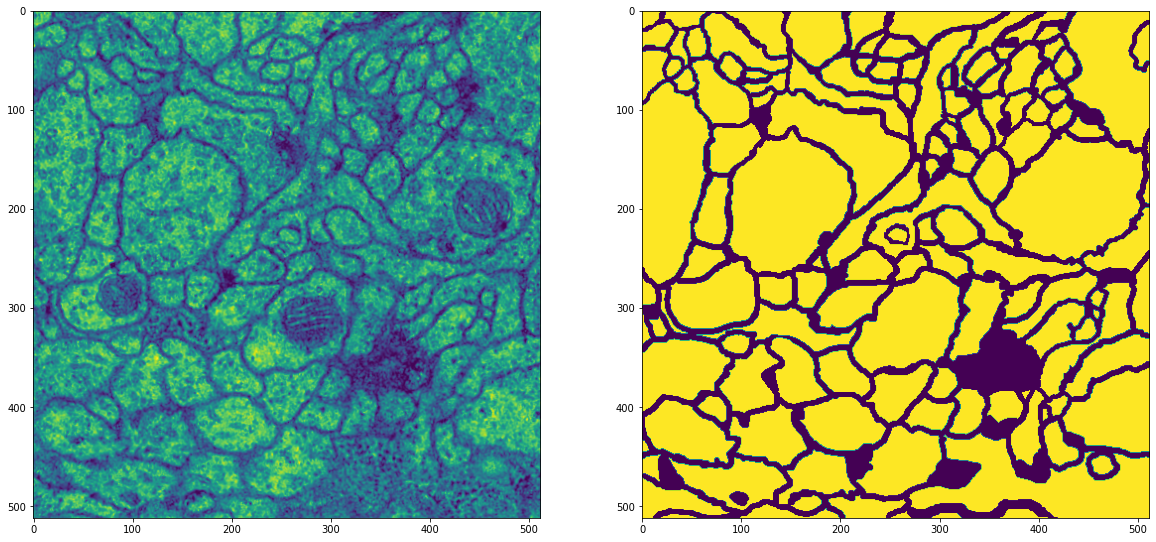

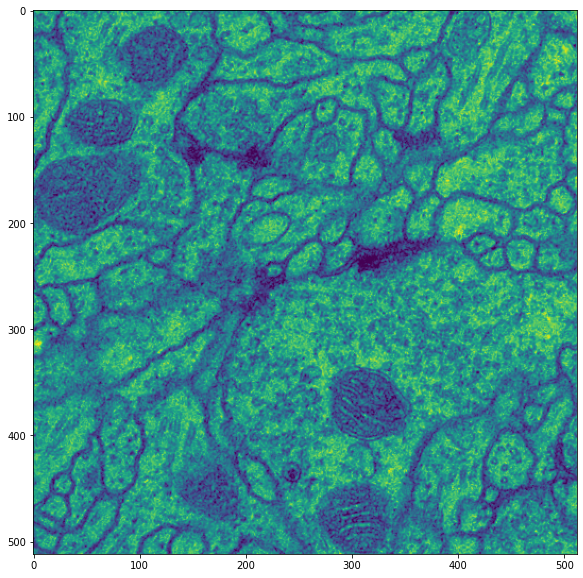

In [3]:
## Show some images from train, val and test sets
fig, ax = plt.subplots(1, 2, figsize=(20,10))

# data_ex = next(iter(train_dataset))
data_ex = train_dataset[24]

ax[0].imshow(data_ex[0].numpy()[0,:,:])
ax[1].imshow(data_ex[1].numpy()[0,:,:])
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(20,10))
data_ex = val_dataset[4]
ax[0].imshow(data_ex[0].numpy()[0,:,:])
ax[1].imshow(data_ex[1].numpy()[0,:,:])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10,10))
data_ex = test_dataset[29]
ax.imshow(data_ex[0].numpy()[0,:,:])
plt.show()


# Initialize and train U-Net
## First setup U-net

In [13]:
## First we init the U-net

# Depth describes levels of unet - default is 5
model = UNet(1, in_channels=1, depth=2, merge_mode='concat')

set_seed(42)

# Test it works
x = Variable(torch.FloatTensor(np.random.random((1, 1, 512, 512))))
out = model(x)
loss = torch.sum(out)
loss.backward()

print("Model parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

Model parameters:  402625


## Init optimizer

In [7]:
# learning_rate = 0.8e-3
learning_rate = 3e-4
weight_decay = 4e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## Training

In [14]:
model, training_loss, validation_loss, global_steps = train_model(model=model, 
            optimizer=optimizer, 
            num_epochs=10, 
            train_dataset=train_dataset, 
            val_dataset=val_dataset, 
            CUDA=False, 
            SAVE_CHECKPOINTS=False)

Epoch 0/9
----------
Epoch 0
Traning loss: 8.53048780709564
Validation loss 1.9768567085266113
Epoch 1/9
----------
Epoch 1
Traning loss: 8.927466620209676
Validation loss 1.9768567085266113
Epoch 2/9
----------
Epoch 2
Traning loss: 8.881896149635743
Validation loss 1.9768567085266113
Epoch 3/9
----------
Epoch 3
Traning loss: 7.730782970946688
Validation loss 1.9768567085266113
Epoch 4/9
----------


In [15]:
npgrid = torchvision.utils.make_grid(torch.cat([inputs.cpu(), targets.cpu(), y_hat.cpu()], dim=0))
print(npgrid.shape)

NameError: name 'inputs' is not defined

In [13]:
np.transpose(npgrid, (1, 2, 0)).shape

torch.Size([516, 1544, 3])

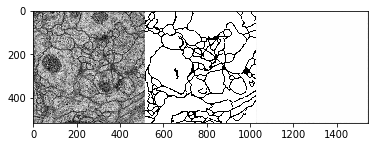

In [16]:
plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')

# Extra

In [9]:
# set_seed(100)
# SAVE_CHECKPOINTS = False

# num_epochs = 20
# itr = 0
# # Save loss for plot
# training_loss=[]
# validation_loss=[]

# print("Start Iter")

# # Status parameters
# global_steps=0

# # Monitoring
# t1=datetime.now()
# t2=datetime.now()
# for epoch in range(num_epochs):
#     # Track loss
#     epoch_training_loss = 0
#     epoch_validation_loss = 0
    
#     model.eval()
#     # For grid in validation set
#     for inputs,targets in validation_dataset:
#         inputs=inputs.unsqueeze(0)
#         targets=targets.unsqueeze(0)
#         # Add channel
#         if CUDA:
#             inputs = inputs.cuda()
#             targets = targets.cuda()

#         # Forward pass to get output/logits
#         y_hat = model(x)
        
#         # Calculate Loss: softmax --> cross entropy loss
#         # outputs shifts channel one place left
#         loss = criterion(y_hat,targets)

#         # Getting gradients w.r.t. parameters
#         epoch_validation_loss += loss.cpu().detach().numpy()
        
#     model.train()
#     # For grid in traning set
#     for inputs,targets in train_dataset:
#         inputs=inputs.unsqueeze(0)
#         targets=targets.unsqueeze(0)
#         # Add channel
#         if CUDA:
#             inputs = inputs.cuda()
#             targets = targets.cuda()

#         # Forward pass to get output/logits
#         y_hat = model(x)
        
#         # Calculate Loss: softmax --> cross entropy loss
#         # outputs shifts channel one place left
#         loss = criterion(y_hat, targets)
        
#         # Clear gradients w.r.t. parameters
#         optimizer.zero_grad()
        
#         # Getting gradients w.r.t. parameters
#         loss.backward()

#         # Updating parameters
#         optimizer.step()

#         # Update loss
#         epoch_training_loss += loss.cpu().detach().numpy()
        
#         # Step taken
#         global_steps+=1
        
#     # Save every epoch
#     if SAVE_CHECKPOINTS:
#         model_name=f'./checkpoint_saves/{type(model).__name__}_{type(criterion).__name__}_checkpoint_epoch_{epoch}_{datetime.now()}'
#         # Send dict to memory
#         torch.save(model.state_dict(), model_name)
        
#     # Early breaking if validationloss increases 3 times
#     if len(validation_loss)>3:
#         if (validation_loss[-1]>=validation_loss[-2]) and (validation_loss[-1]>=validation_loss[-3]) and (validation_loss[-1]>=validation_loss[-4]):
#             break
#     # Save loss for plot
#     training_loss.append(epoch_training_loss)
#     validation_loss.append(epoch_validation_loss)
#     print(f"Epoch {epoch}\nTraning loss: {epoch_training_loss}\nValidation loss {epoch_validation_loss}")

In [10]:
# def plot_images_grid(x: torch.tensor, export_img, title: str = '', nrow=8, padding=2, normalize=False, pad_value=0):
#     """Plot 4D Tensor of images of shape (B x C x H x W) as a grid."""

#     grid = torchvision.utils.make_grid(x, nrow=nrow, padding=padding, normalize=normalize, pad_value=pad_value)
#     npgrid = grid.cpu().numpy()

#     plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')

#     ax = plt.gca()
#     ax.xaxis.set_visible(False)
#     ax.yaxis.set_visible(False)

#     if not (title == ''):
#         plt.title(title)

#     plt.savefig(export_img, bbox_inches='tight', pad_inches=0.1)
#     plt.clf()

# # Example usage
# plot_images_grid(torch.cat([inputs.cpu(), targets.cpu(), y_hat.cpu()], dim=0), 'test.png')

NameError: name 'inputs' is not defined